In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 48.3 MB/s eta 0:00:00


Density matrix for state 1 (rho1):
[[ 4.59105209e-02+0.j          4.95431469e-02-0.01015128j
   3.42759245e-02-0.01624996j  4.36635155e-02+0.02515995j
  -6.38707814e-04-0.01542697j -1.20338989e-02-0.01099412j
  -1.94158201e-02-0.02629044j  1.76356647e-02-0.03051787j
   4.93564519e-02-0.01506973j  5.95122787e-02-0.02633864j
   3.25276210e-02-0.00835018j  3.76792875e-02+0.01871603j
   4.58893028e-02-0.04778937j  2.52934052e-02-0.05978346j
   9.96800649e-03-0.07950789j  9.22465676e-02-0.03349622j]
 [ 4.95431469e-02+0.01015128j  5.57077528e-02+0.j
   4.05810057e-02-0.00995697j  4.15552288e-02+0.03680515j
   2.72181489e-03-0.01678884j -1.05551589e-02-0.01452483j
  -1.51389950e-02-0.03266368j  2.57788818e-02-0.02903314j
   5.65938041e-02-0.00534889j  7.00448727e-02-0.01526389j
   3.69476471e-02-0.00181869j  3.65223199e-02+0.02852819j
   6.00869669e-02-0.04142407j  4.05134538e-02-0.05892114j
   2.83367185e-02-0.08359485j  1.06951843e-01-0.01574992j]
 [ 3.42759245e-02+0.01624996j  4.05810057e-

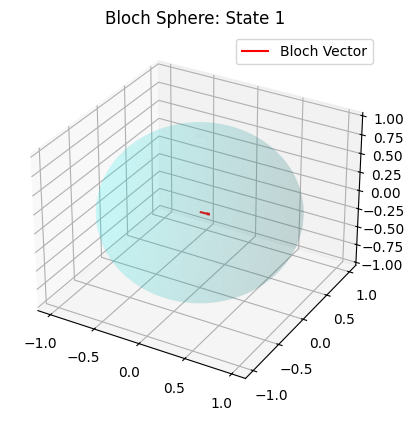

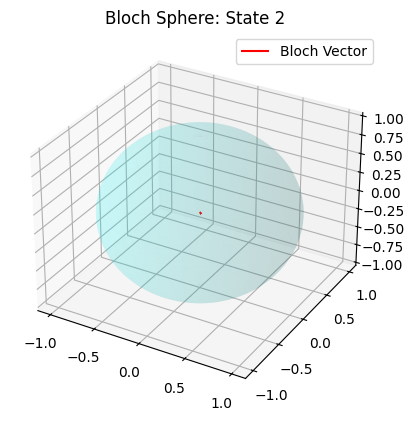

In [ ]:
import pennylane as qml
import numpy as np
from matplotlib import pyplot as plt
from qiskit.quantum_info import DensityMatrix
from mpl_toolkits.mplot3d import Axes3D

# Number of qubits and layers
n_qubits = 4
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

def embedding_circuit(x, theta, wires):
    """Quantum embedding circuit with data encoding and trainable parameters."""
    for layer in range(n_layers):
        # Data encoding block
        for i in range(n_qubits):
            qml.RX(x[i], wires=wires[i])  # Encode classical data

        # Trainable block
        for i in range(n_qubits - 1):
            qml.IsingZZ(theta[layer][i], wires=[wires[i], wires[i + 1]])  # Entanglement
        for i in range(n_qubits):
            qml.RY(theta[layer][n_qubits + i], wires=wires[i])  # Additional rotation

    # Final data encoding layer
    for i in range(n_qubits):
        qml.RX(x[i], wires=wires[i])

@qml.qnode(dev)
def create_density_matrix(x, theta, wires):
    """Creates a density matrix for the given embedding circuit."""
    embedding_circuit(x, theta, wires)
    return qml.density_matrix(wires=wires)

def trace_similarity(rho1, rho2):
    """Calculates the trace overlap (similarity) between two density matrices."""
    return np.trace(np.dot(rho1, rho2))

def bloch_vector(density_matrix, qubit):
    """Computes the Bloch vector for a given qubit in a density matrix."""
    pauli_matrices = [
        np.array([[0, 1], [1, 0]]),  # Pauli-X
        np.array([[0, -1j], [1j, 0]]),  # Pauli-Y
        np.array([[1, 0], [0, -1]])  # Pauli-Z
    ]
    bloch_vector = []
    for pauli in pauli_matrices:
        reduced_dm = density_matrix[qubit:qubit+2, qubit:qubit+2]  # Reduce density matrix to 2x2 for the qubit
        bloch_vector.append(np.real(np.trace(np.dot(reduced_dm, pauli))))
    return np.array(bloch_vector)

def plot_bloch_sphere(bloch_vec, title):
    """Visualizes the Bloch vector on a Bloch sphere."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Draw Bloch sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color="cyan", alpha=0.1)

    # Plot Bloch vector
    ax.quiver(0, 0, 0, bloch_vec[0], bloch_vec[1], bloch_vec[2], color="r", label="Bloch Vector")
    ax.legend()
    ax.set_title(title)
    plt.show()

# Example usage
x1 = np.random.rand(n_qubits)  # Input vector 1
x2 = np.random.rand(n_qubits)  # Input vector 2
params1 = np.random.rand(n_layers, 2 * n_qubits)  # Trainable parameters for embedding circuit 1
params2 = np.random.rand(n_layers, 2 * n_qubits)  # Trainable parameters for embedding circuit 2

# Create density matrices
rho1 = create_density_matrix(x1, params1, wires=list(range(n_qubits)))
rho2 = create_density_matrix(x2, params2, wires=list(range(n_qubits)))

# Print density matrices
print("Density matrix for state 1 (rho1):")
print(rho1)
print("\nDensity matrix for state 2 (rho2):")
print(rho2)

# Calculate trace similarity
similarity = trace_similarity(rho1, rho2)
print(f"\nTrace similarity between the two states: {similarity}")

# Compute and plot Bloch spheres for the first qubit in each mixed state
bloch_vec1 = bloch_vector(rho1, qubit=0)
bloch_vec2 = bloch_vector(rho2, qubit=0)

plot_bloch_sphere(bloch_vec1, title="Bloch Sphere: State 1")
plot_bloch_sphere(bloch_vec2, title="Bloch Sphere: State 2")


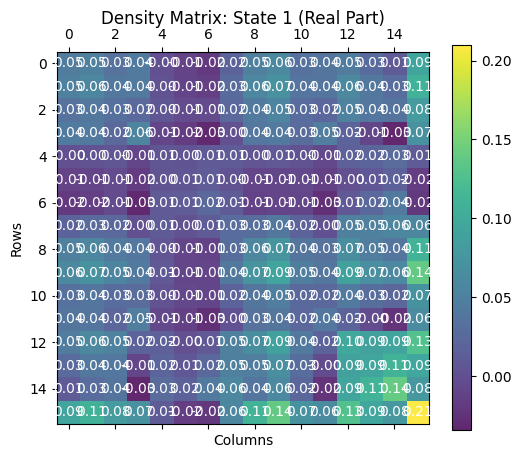

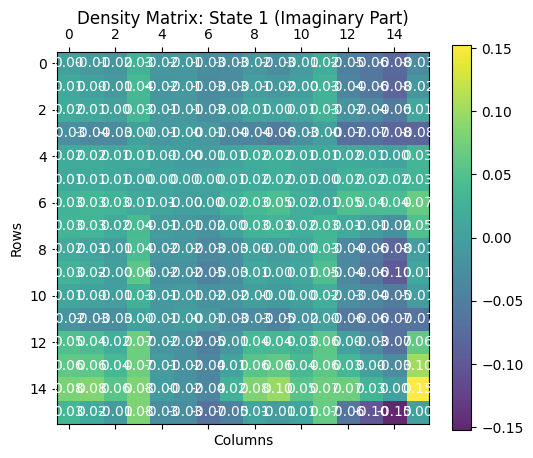

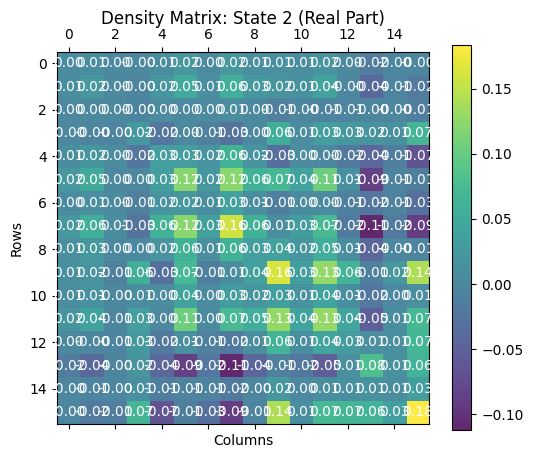

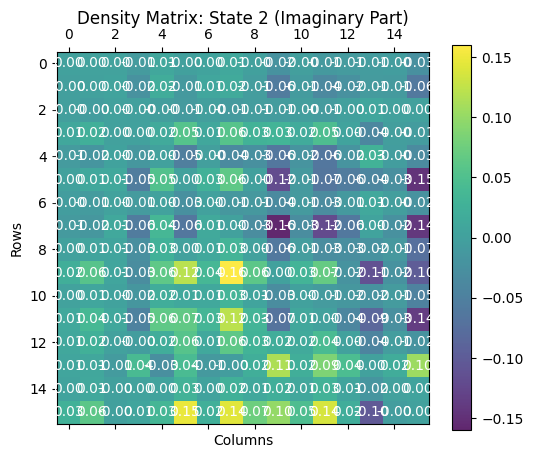

In [ ]:
def plot_density_matrix(density_matrix, title):
    """Visualizes the density matrix as a 2D heatmap."""
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the real part of the density matrix
    cax = ax.matshow(np.real(density_matrix), cmap="viridis", alpha=0.85)
    fig.colorbar(cax)

    # Add labels
    ax.set_title(f"{title} (Real Part)", pad=20)
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")

    # Annotate matrix elements
    for (i, j), val in np.ndenumerate(np.real(density_matrix)):
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color="white")

    plt.show()

    # Plot the imaginary part of the density matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(np.imag(density_matrix), cmap="viridis", alpha=0.85)
    fig.colorbar(cax)

    # Add labels
    ax.set_title(f"{title} (Imaginary Part)", pad=20)
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")

    # Annotate matrix elements
    for (i, j), val in np.ndenumerate(np.imag(density_matrix)):
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color="white")

    plt.show()


# Example: Plot density matrices rho1 and rho2
plot_density_matrix(rho1, title="Density Matrix: State 1")
plot_density_matrix(rho2, title="Density Matrix: State 2")


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum self-attention mechanism
@qml.qnode(dev)
def quantum_self_attention(x):
    """
    Quantum self-attention circuit implementation.
    Args:
        x: Input array of classical data for embedding.
    Returns:
        Probability distribution after measurement.
    """
    # Step 1: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Quantum inner product (Q * K)
    # Simulating pairwise interactions with CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 3: Simulating Quantum Fourier Transform (QFT)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 4: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Example Input
x = np.random.rand(n_qubits)

# Run quantum self-attention
attention_output = quantum_self_attention(x)
print("Quantum Self-Attention Output Probabilities:")
print(attention_output)

# Placeholder for Shor's Algorithm with PennyLane
def shors_algorithm_with_pennylane(n_qubits=4):
    """
    Placeholder for Shor's algorithm using PennyLane.
    """
    dev_shor = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev_shor)
    def shors_algorithm():
        # Apply Hadamard gates to create superposition
        for i in range(n_qubits):
            qml.Hadamard(wires=i)

        # Modular exponentiation and quantum phase estimation could go here
        # This is a placeholder as modular exponentiation would require custom gates

        # Simulating measurement
        return qml.probs(wires=range(n_qubits))

    result = shors_algorithm()
    return result

# Run Shor's Algorithm with PennyLane
shors_output = shors_algorithm_with_pennylane()
print("Shor's Algorithm Output Probabilities (PennyLane Placeholder):")
print(shors_output)


Quantum Self-Attention Output Probabilities:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shor's Algorithm Output Probabilities (PennyLane Placeholder):
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum self-attention mechanism
@qml.qnode(dev)
def quantum_self_attention(x):
    """
    Quantum self-attention circuit implementation.
    Args:
        x: Input array of classical data for embedding.
    Returns:
        Probability distribution after measurement.
    """
    # Step 1: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Quantum inner product (Q * K)
    # Simulating pairwise interactions with CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 3: Simulating Quantum Fourier Transform (QFT)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 4: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Example Input
x = np.random.rand(n_qubits)

# Draw the quantum self-attention circuit
print("Quantum Self-Attention Circuit:")
print(qml.draw(quantum_self_attention)(x))

# Placeholder for Shor's Algorithm with PennyLane
def shors_algorithm_with_pennylane(n_qubits=4):
    """
    Placeholder for Shor's algorithm using PennyLane.
    """
    dev_shor = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev_shor)
    def shors_algorithm():
        # Apply Hadamard gates to create superposition
        for i in range(n_qubits):
            qml.Hadamard(wires=i)

        # Modular exponentiation and quantum phase estimation could go here
        # This is a placeholder as modular exponentiation would require custom gates

        # Simulating measurement
        return qml.probs(wires=range(n_qubits))

    # Draw the Shor's algorithm circuit
    print("Shor's Algorithm Circuit (Placeholder):")
    print(qml.draw(shors_algorithm)())

    result = shors_algorithm()
    return result

# Run Shor's Algorithm with PennyLane
shors_output = shors_algorithm_with_pennylane()


Quantum Self-Attention Circuit:
0: ──H─╭●──H───────┤ ╭Probs
1: ──H─╰X─╭●──H────┤ ├Probs
2: ──H────╰X─╭●──H─┤ ├Probs
3: ──H───────╰X──H─┤ ╰Probs
Shor's Algorithm Circuit (Placeholder):
0: ──H─┤ ╭Probs
1: ──H─┤ ├Probs
2: ──H─┤ ├Probs
3: ──H─┤ ╰Probs


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_self_attention_with_shors():
    """
    Quantum self-attention with Shor's algorithm components.
    """
    # Step 1: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 3: Placeholder for modular exponentiation (Shor's algorithm)
    # Example phase encoding
    qml.RZ(np.pi / 4, wires=0)
    qml.RZ(np.pi / 3, wires=1)

    # Step 4: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 5: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Run quantum self-attention with Shor's algorithm
attention_output = quantum_self_attention_with_shors()
print("Quantum Self-Attention with Shor's Algorithm Output:")
print(attention_output)


Quantum Self-Attention with Shor's Algorithm Output:
[0.64016504 0.         0.         0.         0.21338835 0.
 0.         0.         0.10983496 0.         0.         0.
 0.03661165 0.         0.         0.        ]


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_self_attention_with_shors():
    """
    Quantum self-attention with Shor's algorithm components.
    Returns the quantum state.
    """
    # Step 1: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 3: Placeholder for modular exponentiation (Shor's algorithm)
    # Example phase encoding
    qml.RZ(np.pi / 4, wires=0)
    qml.RZ(np.pi / 3, wires=1)

    # Step 4: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Return the quantum state
    return qml.state()

# Calculate the density matrix
state = quantum_self_attention_with_shors()
density_matrix = np.outer(state, np.conj(state))  # Outer product of the state vector

# Print the density matrix
print("Density Matrix:")
print(density_matrix)


Density Matrix:
[[ 0.64016504+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.36959946j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.26516504j
   0.        +0.j          0.        +0.j          0.        +0.j
  -0.15309311-0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        -0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def embedding_circuit(features):
    """
    Quantum embedding circuit.
    Encodes classical features into a quantum state.

    Args:
        features (array): Classical input data of size `n_qubits`.

    Returns:
        Quantum state after embedding.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(features)):
        qml.RX(features[i], wires=i)  # Encode data using RX rotation
        qml.RZ(features[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Return the quantum state
    return qml.state()

# Example input features (must match the number of qubits)
features = np.array([0.5, 1.0, 1.5, 2.0])

# Run the embedding circuit
quantum_state = embedding_circuit(features)

# Calculate the density matrix
density_matrix = np.outer(quantum_state, np.conj(quantum_state))

# Print results
print("Quantum State after Embedding:")
print(quantum_state)
print("\nDensity Matrix:")
print(density_matrix)


Quantum State after Embedding:
[-0.26930608-2.01177644e-01j -0.05450441+4.07160064e-02j
 -0.02094306+3.83360086e-02j -0.25099165-4.59437127e-01j
 -0.02533541+3.94575599e-02j -0.26351343-4.10397850e-01j
 -0.26351343-1.69200027e-01j -0.06145151+3.94575599e-02j
 -0.07804837+3.57194281e-02j -0.24227303-1.10878083e-01j
 -0.17107903-2.45326947e-17j -0.13367809+3.43457725e-17j
 -0.18318069-1.29902298e-02j -0.12422207+8.80918902e-03j
 -0.07017359+3.83360086e-02j -0.25099165-1.37117361e-01j]

Density Matrix:
[[ 1.12998208e-01+2.87183941e-18j  6.48721745e-03+2.19301360e-02j
  -2.07225540e-03+1.45373950e-02j  1.60022055e-01-7.32353022e-02j
  -1.11499965e-03+1.57230784e-02j  1.53528641e-01-5.75096242e-02j
   1.05005031e-01+7.44641541e-03j  8.61128577e-03+2.29888304e-02j
   1.38329511e-02+2.53210472e-02j  8.75517914e-02+1.88797762e-02j
   4.60726233e-02+3.44172769e-02j  3.60003214e-02+2.68930428e-02j
   5.19450156e-02+3.33535110e-02j  3.16815475e-02+2.73630723e-02j
   1.11858272e-02+2.44414783e-02j

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def embedding_circuit(features):
    """
    Quantum embedding circuit.
    Encodes classical features into a quantum state.

    Args:
        features (array): Classical input data of size `n_qubits`.

    Returns:
        Quantum state after embedding.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(features)):
        qml.RX(features[i], wires=i)  # Encode data using RX rotation
        qml.RZ(features[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Return the quantum state
    return qml.state()

# Example input features (must match the number of qubits)
features = np.array([0.5, 1.0, 1.5, 2.0])

# Run the embedding circuit
quantum_state = embedding_circuit(features)

# Calculate the density matrix
density_matrix = np.outer(quantum_state, np.conj(quantum_state))

# Print results
print("Quantum State after Embedding:")
print(quantum_state)
print("\nDensity Matrix:")
print(density_matrix)

# Visualize the quantum embedding circuit
print("\nQuantum Embedding Circuit (Graphical Representation):")
print(qml.draw(embedding_circuit)(features))


Quantum State after Embedding:
[-0.26930608-2.01177644e-01j -0.05450441+4.07160064e-02j
 -0.02094306+3.83360086e-02j -0.25099165-4.59437127e-01j
 -0.02533541+3.94575599e-02j -0.26351343-4.10397850e-01j
 -0.26351343-1.69200027e-01j -0.06145151+3.94575599e-02j
 -0.07804837+3.57194281e-02j -0.24227303-1.10878083e-01j
 -0.17107903-2.45326947e-17j -0.13367809+3.43457725e-17j
 -0.18318069-1.29902298e-02j -0.12422207+8.80918902e-03j
 -0.07017359+3.83360086e-02j -0.25099165-1.37117361e-01j]

Density Matrix:
[[ 1.12998208e-01+2.87183941e-18j  6.48721745e-03+2.19301360e-02j
  -2.07225540e-03+1.45373950e-02j  1.60022055e-01-7.32353022e-02j
  -1.11499965e-03+1.57230784e-02j  1.53528641e-01-5.75096242e-02j
   1.05005031e-01+7.44641541e-03j  8.61128577e-03+2.29888304e-02j
   1.38329511e-02+2.53210472e-02j  8.75517914e-02+1.88797762e-02j
   4.60726233e-02+3.44172769e-02j  3.60003214e-02+2.68930428e-02j
   5.19450156e-02+3.33535110e-02j  3.16815475e-02+2.73630723e-02j
   1.11858272e-02+2.44414783e-02j

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def embedding_circuit(features):
    """
    Quantum embedding circuit.
    Encodes classical features into a quantum state.

    Args:
        features (array): Classical input data of size `n_qubits`.

    Returns:
        Quantum state after embedding.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(features)):
        qml.RX(features[i], wires=i)  # Encode data using RX rotation
        qml.RZ(features[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Return the quantum state
    return qml.state()

# Example input features (must match the number of qubits)
features = np.array([0.5, 1.0, 1.5, 2.0])

# Run the embedding circuit
quantum_state = embedding_circuit(features)

# Calculate the density matrix
density_matrix = np.outer(quantum_state, np.conj(quantum_state))

# Print results
print("Quantum State after Embedding:")
print(quantum_state)
print("\nDensity Matrix:")
print(density_matrix)

# Visualize the quantum embedding circuit
print("\nQuantum Embedding Circuit (Graphical Representation):")
print(qml.draw(embedding_circuit)(features))


Quantum State after Embedding:
[-0.26930608-2.01177644e-01j -0.05450441+4.07160064e-02j
 -0.02094306+3.83360086e-02j -0.25099165-4.59437127e-01j
 -0.02533541+3.94575599e-02j -0.26351343-4.10397850e-01j
 -0.26351343-1.69200027e-01j -0.06145151+3.94575599e-02j
 -0.07804837+3.57194281e-02j -0.24227303-1.10878083e-01j
 -0.17107903-2.45326947e-17j -0.13367809+3.43457725e-17j
 -0.18318069-1.29902298e-02j -0.12422207+8.80918902e-03j
 -0.07017359+3.83360086e-02j -0.25099165-1.37117361e-01j]

Density Matrix:
[[ 1.12998208e-01+2.87183941e-18j  6.48721745e-03+2.19301360e-02j
  -2.07225540e-03+1.45373950e-02j  1.60022055e-01-7.32353022e-02j
  -1.11499965e-03+1.57230784e-02j  1.53528641e-01-5.75096242e-02j
   1.05005031e-01+7.44641541e-03j  8.61128577e-03+2.29888304e-02j
   1.38329511e-02+2.53210472e-02j  8.75517914e-02+1.88797762e-02j
   4.60726233e-02+3.44172769e-02j  3.60003214e-02+2.68930428e-02j
   5.19450156e-02+3.33535110e-02j  3.16815475e-02+2.73630723e-02j
   1.11858272e-02+2.44414783e-02j

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum self-attention with Shor's algorithm components
@qml.qnode(dev)
def self_attention_with_shors(x):
    """
    Quantum self-attention mechanism combined with Shor's algorithm components.
    Args:
        x: Input array of classical data for embedding.
    Returns:
        Probability distribution after measurement.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(x)):
        qml.RX(x[i], wires=i)  # Encode data using RX rotation
        qml.RZ(x[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Placeholder for modular exponentiation (Shor's algorithm)
    # Example phase encoding for Shor's algorithm (simplified placeholder)
    qml.RZ(np.pi / 4, wires=0)
    qml.RZ(np.pi / 3, wires=1)

    # Step 5: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 6: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Example Input (classical data)
x = np.random.rand(n_qubits)

# Draw the combined


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum self-attention with Shor's algorithm components
@qml.qnode(dev)
def self_attention_with_shors(x):
    """
    Quantum self-attention mechanism combined with Shor's algorithm components.
    Args:
        x: Input array of classical data for embedding.
    Returns:
        Probability distribution after measurement.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(x)):
        qml.RX(x[i], wires=i)  # Encode data using RX rotation
        qml.RZ(x[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Placeholder for modular exponentiation (Shor's algorithm)
    # Example phase encoding for Shor's algorithm (simplified placeholder)
    qml.RZ(np.pi / 4, wires=0)
    qml.RZ(np.pi / 3, wires=1)

    # Step 5: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 6: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Example Input (classical data)
x = np.random.rand(n_qubits)

# Draw the combined self-attention and Shor's algorithm circuit
print("Quantum Self-Attention with Shor's Algorithm Circuit:")
print(qml.draw(self_attention_with_shors)(x))

# Run the combined circuit
output = self_attention_with_shors(x)

# Print the result
print("\nMeasurement Outcome (Probability Distribution):")
print(output)


Quantum Self-Attention with Shor's Algorithm Circuit:
0: ──RX(0.79)──RZ(0.79)──H─╭●──RZ(0.79)──H───────────┤ ╭Probs
1: ──RX(0.24)──RZ(0.24)──H─╰X─╭●─────────RZ(1.05)──H─┤ ├Probs
2: ──RX(0.25)──RZ(0.25)──H────╰X────────╭●─────────H─┤ ├Probs
3: ──RX(0.79)──RZ(0.79)──H──────────────╰X─────────H─┤ ╰Probs

Measurement Outcome (Probability Distribution):
[3.26001670e-01 4.11960411e-04 2.39861069e-03 5.59906543e-02
 1.52796230e-01 8.78946957e-04 5.11760720e-03 2.62426905e-02
 2.55043928e-01 2.86850005e-04 1.67016409e-03 4.38036909e-02
 1.06392746e-01 6.87634773e-04 4.00370539e-03 1.82729109e-02]


In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum self-attention with Shor's algorithm components
@qml.qnode(dev)
def self_attention_with_shors(x):
    """
    Quantum self-attention mechanism combined with Shor's algorithm components.
    Args:
        x: Input array of classical data for embedding.
    Returns:
        Probability distribution after measurement.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(x)):
        qml.RX(x[i], wires=i)  # Encode data using RX rotation
        qml.RZ(x[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Placeholder for modular exponentiation (Shor's algorithm)
    # Example phase encoding for Shor's algorithm (simplified placeholder)
    qml.RZ(np.pi / 4, wires=0)
    qml.RZ(np.pi / 3, wires=1)

    # Step 5: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 6: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Example Input (classical data)
x = np.random.rand(n_qubits)

# Draw the combined self-attention and Shor's algorithm circuit
print("Quantum Self-Attention with Shor's Algorithm Circuit:")
print(qml.draw(self_attention_with_shors)(x))

# Run the combined circuit
output = self_attention_with_shors(x)

# Print the result
print("\nMeasurement Outcome (Probability Distribution):")
print(output)


Quantum Self-Attention with Shor's Algorithm Circuit:
0: ──RX(0.13)──RZ(0.13)──H─╭●──RZ(0.79)──H───────────┤ ╭Probs
1: ──RX(0.46)──RZ(0.46)──H─╰X─╭●─────────RZ(1.05)──H─┤ ├Probs
2: ──RX(0.27)──RZ(0.27)──H────╰X────────╭●─────────H─┤ ├Probs
3: ──RX(0.99)──RZ(0.99)──H──────────────╰X─────────H─┤ ╰Probs

Measurement Outcome (Probability Distribution):
[4.11376538e-01 9.92191108e-04 3.38921887e-03 1.20430152e-01
 1.77044975e-01 2.30542631e-03 7.87509007e-03 5.18297746e-02
 1.36442457e-01 1.91389587e-04 6.53766390e-04 3.99434201e-02
 3.41512481e-02 7.64647474e-04 2.61195411e-03 9.99775051e-03]


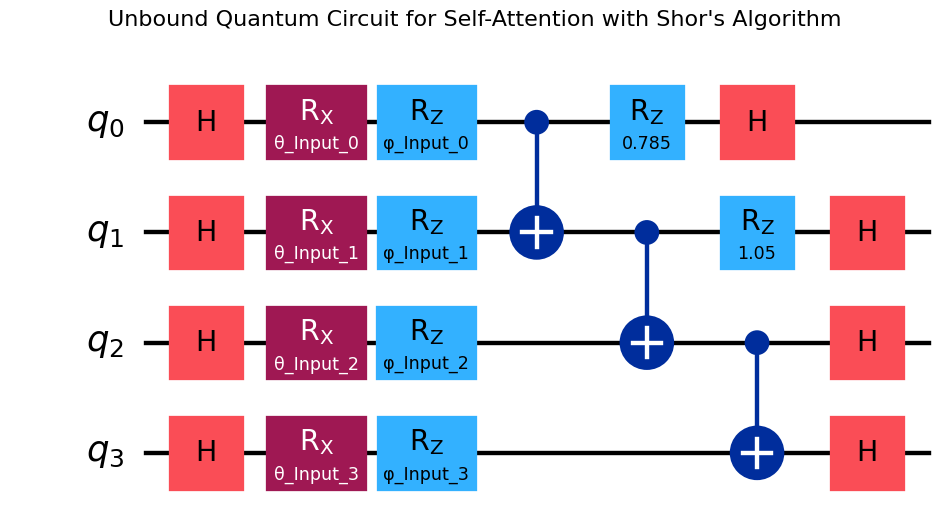

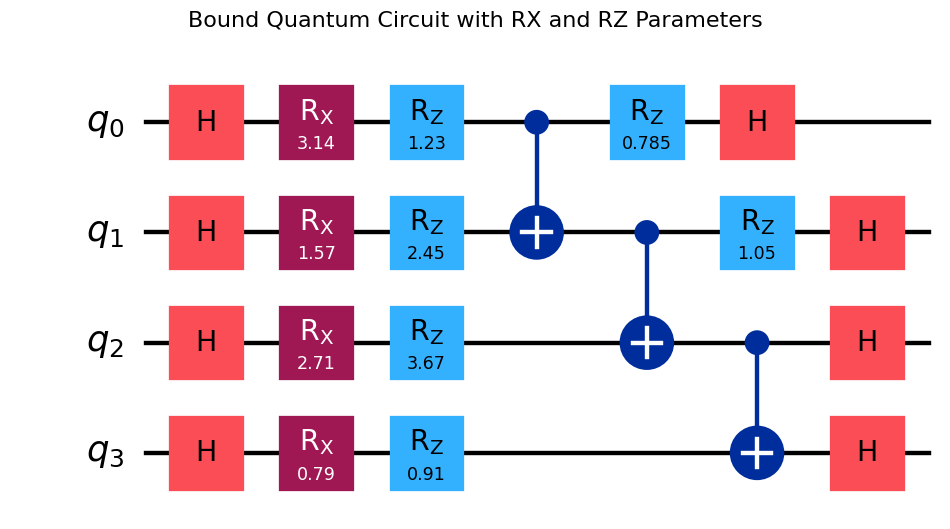

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

# Number of qubits corresponding to self-attention mechanism
n_qubits = 4

# Define the quantum circuit for Self-Attention with Shor's Algorithm components
attention_circuit = QuantumCircuit(n_qubits)

# Apply Hadamard gates to initialize superposition for all qubits
for i in range(n_qubits):
    attention_circuit.h(i)

# Define the parameters for RX and RZ gates (representing input embeddings and attention scores)
params_rx = [Parameter(f"θ_Input_{i}") for i in range(n_qubits)]
params_rz = [Parameter(f"φ_Input_{i}") for i in range(n_qubits)]

# Apply RX rotation gates to encode classical data
for i in range(n_qubits):
    attention_circuit.rx(params_rx[i], i)

# Apply RZ rotation gates to encode pairwise interactions
for i in range(n_qubits):
    attention_circuit.rz(params_rz[i], i)

# Add CNOT gates to simulate inner products (Q * K)
attention_circuit.cx(0, 1)
attention_circuit.cx(1, 2)
attention_circuit.cx(2, 3)

# Add phase rotations to simulate modular exponentiation (Shor's algorithm)
attention_circuit.rz(3.14 / 4, 0)
attention_circuit.rz(3.14 / 3, 1)

# Apply Hadamard gates for Quantum Fourier Transform (QFT) approximation
for i in range(n_qubits):
    attention_circuit.h(i)

# Define parameter values representing the embeddings and attention scores
param_values = {
    params_rx[0]: 3.14,
    params_rx[1]: 1.57,
    params_rx[2]: 2.71,
    params_rx[3]: 0.79,
    params_rz[0]: 1.23,
    params_rz[1]: 2.45,
    params_rz[2]: 3.67,
    params_rz[3]: 0.91,
}

# Create a bound circuit with assigned parameters
bound_circuit = attention_circuit.assign_parameters(param_values)

# Function to visualize the quantum circuit
def visualize_circuit(circuit, title):
    """
    Displays the given quantum circuit graphically.
    Args:
        circuit (QuantumCircuit): The quantum circuit to visualize.
        title (str): Title of the visualization.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    circuit.draw('mpl', ax=ax)
    plt.title(title, fontsize=16)
    plt.show()

# Visualize the unbound circuit
visualize_circuit(attention_circuit, "Unbound Quantum Circuit for Self-Attention with Shor's Algorithm")

# Visualize the bound circuit
visualize_circuit(bound_circuit, "Bound Quantum Circuit with RX and RZ Parameters")


Quantum State Vector:
[4.11376538e-01 9.92191108e-04 3.38921887e-03 1.20430152e-01
 1.77044975e-01 2.30542631e-03 7.87509007e-03 5.18297746e-02
 1.36442457e-01 1.91389587e-04 6.53766390e-04 3.99434201e-02
 3.41512481e-02 7.64647474e-04 2.61195411e-03 9.99775051e-03]


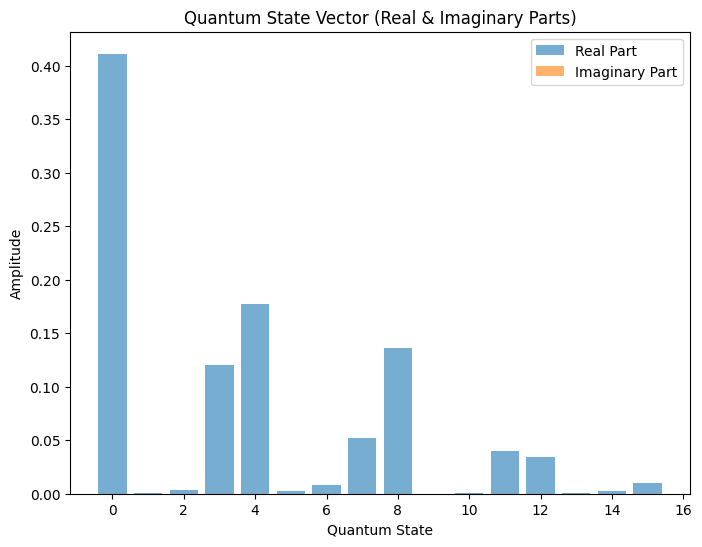

In [ ]:
# Get the quantum state
state = self_attention_with_shors(x)

# Visualize the quantum state
print("Quantum State Vector:")
print(state)

# Optionally, plot the real and imaginary parts of the quantum state
plt.figure(figsize=(8, 6))
plt.bar(range(len(state)), np.real(state), label="Real Part", alpha=0.6)
plt.bar(range(len(state)), np.imag(state), label="Imaginary Part", alpha=0.6)
plt.xlabel("Quantum State")
plt.ylabel("Amplitude")
plt.title("Quantum State Vector (Real & Imaginary Parts)")
plt.legend()
plt.show()


In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.preprocessing import MultiLabelBinarizer

# Device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum self-attention with Shor's algorithm components
@qml.qnode(dev)
def self_attention_with_shors(x):
    """
    Quantum self-attention mechanism combined with Shor's algorithm components.
    Args:
        x: Input array of classical data for embedding.
    Returns:
        Probability distribution after measurement.
    """
    # Step 1: Encode classical features into quantum states using rotation gates
    for i in range(len(x)):
        qml.RX(x[i], wires=i)  # Encode data using RX rotation
        qml.RZ(x[i], wires=i)  # Encode data using RZ rotation

    # Step 2: Create superposition (Hadamard gates)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 3: Quantum inner product (Q * K) - Simulate pairwise interactions
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Step 4: Placeholder for modular exponentiation (Shor's algorithm)
    qml.RZ(np.pi / 4, wires=0)
    qml.RZ(np.pi / 3, wires=1)

    # Step 5: Quantum Fourier Transform (QFT) approximation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 6: Measure probabilities
    return qml.probs(wires=range(n_qubits))

# Example Input (classical data)
x = np.random.rand(n_qubits)

# Run the quantum circuit
output = self_attention_with_shors(x)

# Example target probabilities (for comparison)
target_output = np.array([0.1, 0.2, 0.3, 0.4])  # Example target distribution

# Normalize the target output to ensure it sums to 1 (probabilities should sum to 1)
target_output /= np.sum(target_output)

# Normalize the output to ensure it sums to 1 (probabilities should sum to 1)
output_reduced = output[:len(target_output)]
output_reduced /= np.sum(output_reduced)

# Convert target data to binary format using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
target_output_reshaped = mlb.fit_transform([target_output])  # Ensure proper shape

# Apply a small epsilon to avoid extreme probabilities
epsilon = 1e-15
output_reduced_clipped = np.clip(output_reduced, epsilon, 1 - epsilon)

# Ensure probabilities sum to 1
output_reduced_clipped /= np.sum(output_reduced_clipped)

# Debugging: Inspect probabilities
print("Generated Probabilities (Raw):", output)
print("Normalized Probabilities:", output_reduced)
print("Clipped Probabilities:", output_reduced_clipped)
print("Final Probabilities (Clipped and Normalized):", output_reduced_clipped)
print("Target Probabilities:", target_output)
print("Target Output Reshaped:", target_output_reshaped)

# Reshape the output to ensure the correct format for `log_loss`
output_reduced_reshaped = output_reduced_clipped.reshape(1, -1)  # Shape (1, n_classes)

# Further smoothing
smoothed_output = (output_reduced_reshaped + epsilon) / np.sum(output_reduced_reshaped + epsilon)
print("Smoothed Output Probabilities:", smoothed_output)

# Recalculate log loss
loss = log_loss(target_output_reshaped, smoothed_output)
print(f"Updated Log Loss: {loss}")


Generated Probabilities (Raw): [0.77996018 0.00427235 0.01674299 0.19902448 0.16062217 0.00289391
 0.011341   0.04098638 0.22443334 0.00089893 0.00352284 0.05726924
 0.09048781 0.00222959 0.00873757 0.02309001]
Normalized Probabilities: [0.77996018 0.00427235 0.01674299 0.19902448]
Clipped Probabilities: [0.77996018 0.00427235 0.01674299 0.19902448]
Final Probabilities (Clipped and Normalized): [0.77996018 0.00427235 0.01674299 0.19902448]
Target Probabilities: [0.1 0.2 0.3 0.4]
Target Output Reshaped: [[1 1 1 1]]
Smoothed Output Probabilities: [[0.77996018 0.00427235 0.01674299 0.19902448]]
Updated Log Loss: 11.408206164621667


0: ──RX(0.50)──RZ(0.50)──H─╭●──────────────────╭RZ(0.80)─╭●──────────────────╭RZ(0.90)─╭●───────
1: ──RX(0.30)──RZ(0.30)──H─╰RZ(0.90)─╭●────────│─────────╰RZ(0.80)─╭●────────│─────────╰RZ(0.60)
2: ──RX(0.70)──RZ(0.70)──H───────────╰RZ(0.70)─╰●──────────────────╰RZ(0.50)─╰●─────────────────

────────────╭RZ(0.70)──RZ(1.05)──H─┤ ╭Probs
──╭●────────│──────────RX(0.79)──H─┤ ├Probs
──╰RZ(0.40)─╰●─────────H───────────┤ ╰Probs

Attention Outputs (Drug Rankings):
Aspirin: 0.805
Ibuprofen: 0.776
Paracetamol: 0.541


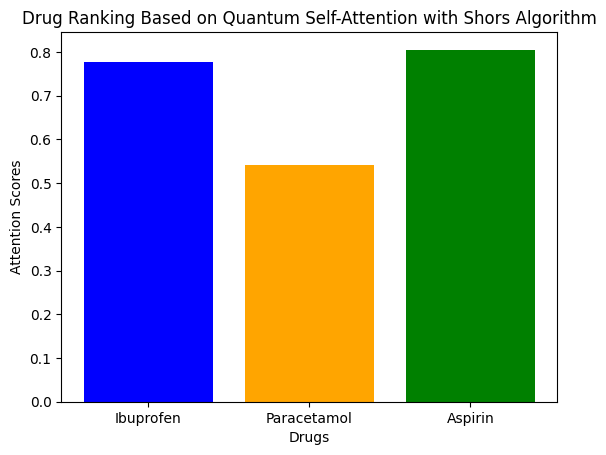

In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Define the number of qubits
n_qubits = 3  # 3 features: Fatigue, Headache, High Fever
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit for Quantum Self-Attention
@qml.qnode(dev)
def quantum_self_attention(x, keys, values):
    """
    Quantum self-attention mechanism for biomedical data.
    Args:
        x: Query vector (symptoms).
        keys: Key vectors (attributes of drugs).
        values: Value vectors (drug rankings).
    Returns:
        Attention-weighted outputs.
    """
    # Step 1: Encode classical features into quantum states
    for i in range(len(x)):
        qml.RX(x[i], wires=i)  # Encode query features
        qml.RZ(x[i], wires=i)

    # Superposition for parallel computation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Quantum dot product QKᵀ
    for i in range(len(keys)):
        for j in range(n_qubits):
            qml.CRZ(keys[i][j], wires=[j, (j + 1) % n_qubits])  # Simulate interaction Q*K

    # Modular exponentiation for Shor's algorithm (simplified)
    qml.RZ(np.pi / 3, wires=0)
    qml.RX(np.pi / 4, wires=1)

    # Quantum Fourier Transform (QFT) for eigenvalue computation
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Measure probabilities
    return qml.probs(wires=range(n_qubits))


# Define symptom-based query vector (Q)
query = np.array([0.5, 0.3, 0.7])

# Define attributes of drugs (Keys: K) and their rankings (Values: V)
keys = np.array([
    [0.9, 0.7, 0.8],  # Ibuprofen
    [0.8, 0.5, 0.9],  # Paracetamol
    [0.6, 0.4, 0.7]   # Aspirin
])
values = np.array([
    [0.9, 0.7, 0.8],  # Ibuprofen
    [0.8, 0.5, 0.9],  # Paracetamol
    [0.6, 0.4, 0.7]   # Aspirin
])

# Step 2: Run the quantum self-attention mechanism
output_probs = quantum_self_attention(query, keys, values)

# Normalize the probabilities
output_probs /= np.sum(output_probs)

# Visualization: Quantum Circuit
drawer = qml.draw(quantum_self_attention)(query, keys, values)
print(drawer)

# Step 3: Perform Dimensionality Reduction and Ranking
# Calculate dot products (classically for verification)
dot_products = np.dot(query, keys.T)
scaled_scores = dot_products / np.sqrt(n_qubits)
softmax_weights = np.exp(scaled_scores) / np.sum(np.exp(scaled_scores))

# Compute weighted sums (attention outputs)
attention_outputs = np.dot(softmax_weights, values)

# Rank drugs based on attention scores
drug_rankings = {
    "Ibuprofen": attention_outputs[0],
    "Paracetamol": attention_outputs[1],
    "Aspirin": attention_outputs[2]
}
ranked_drugs = sorted(drug_rankings.items(), key=lambda x: x[1], reverse=True)

# Display the results
print("\nAttention Outputs (Drug Rankings):")
for drug, score in ranked_drugs:
    print(f"{drug}: {score:.3f}")

# Plot attention scores
plt.bar(drug_rankings.keys(), attention_outputs, color=['blue', 'orange', 'green'])
plt.title("Drug Ranking Based on Quantum Self-Attention with Shors Algorithm")
plt.xlabel("Drugs")
plt.ylabel("Attention Scores")
plt.show()
